# Laboratorio 11
## Esercizio 11.3
Svolgo la medesima analisi dell'esercizio 11.2, applicandola alla funzione a due variabili
$$f(x,y)=\sin(x^2+y^2)$$
per $x\in[-1.5,1.5]$ e $y\in[-1.5,1.5]$. Utilizzo un dataset di training con $N_{train}=10000$ ed un dataset di test con $N_{test}=200$.

In [1]:
import numpy as np

def f(x,y,sigma):
    return np.random.normal(np.sin(x**2 + y**2),sigma)

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1.5, 1.5, 10000)
x_valid = np.random.uniform(-1.5, 1.5, 200)

y_train = np.random.uniform(-1.5, 1.5, 10000)
y_valid = np.random.uniform(-1.5, 1.5, 200)


sigma = 0.2 # noise standard deviation, for the moment it is absent
z_train = f(x_train,y_train,sigma) # actual measures from which we want to guess regression parameters
z_valid = f(x_valid,y_valid,sigma)

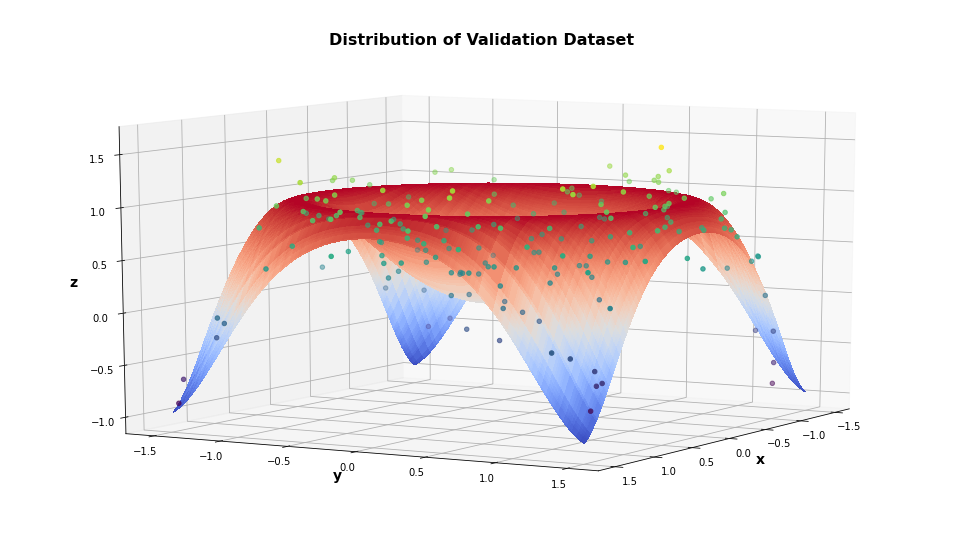

In [3]:
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.mplot3d import Axes3D

fontsize = 16


fig = plt.figure(figsize = (17,10))
ax = fig.add_subplot(111, projection='3d')
X_valid, Y_valid = np.meshgrid(sorted(x_valid), sorted(y_valid))
z_target = np.array(f(np.ravel(X_valid), np.ravel(Y_valid),0.))
Z_target = z_target.reshape(X_valid.shape)
z_target = f(x_valid,y_valid,0.0) # ideal (target) linear function



ax.plot_surface(X_valid, Y_valid, Z_target, rstride=1, cstride=1, cmap="coolwarm",
    linewidth=0, antialiased=False)
ax.scatter(x_valid, y_valid, z_valid, c = z_valid)


ax.set_xlabel('x', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('y', fontsize = 14, fontweight = 'bold')
ax.set_zlabel('z', fontsize = 14, fontweight = 'bold')
ax.set_title('Distribution of Validation Dataset', fontsize = fontsize, fontweight = 'bold')
ax.view_init(10, 30)
plt.show()




Vista la maggiore complessità del problema, costruisco già dal principio una rete neurale più profonda, con 3 strati nascosti. Procedo con una prima grid search sul numero di neuroni e la funzione di attivazione:

In [4]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


# compile the model choosing optimizer, loss and metrics objects
#model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

def NN_model(inputsize,n_layers,n_neuron,activation,optimizer,loss):
    model=tf.keras.Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation=activation,input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation=activation))
    model.add(Dense(1))
    model.compile(loss=loss,optimizer=optimizer,metrics=['mse'])
    return model

In [5]:
# Define tunable parameters"
n_layers = 3                                  #Define number of hidden layers in the model
n_neuron = np.linspace(5,50,10)                #Define number of neurons per layer
epochs = 100                                  #Number of reiterations over the input data
activation = ["tanh","relu","sigmoid","selu"]
loss = "mse"
optimizer = "sgd"


history = []

Train_loss=np.zeros((len(n_neuron),len(activation)))      #Define matrices to store accuracy scores as a function
Test_loss=np.zeros((len(n_neuron),len(activation)))       #of n_epochs and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    row = []
    for j in range(len(activation)):      #accuracy scores 
        DNN_model=NN_model(2,n_layers,n_neuron[i],activation[j],optimizer,loss)
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=100, mode='auto')

        row.append(DNN_model.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
          batch_size=32, epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
          callbacks=[earlystop]))
        
        Train_loss[i,j]=DNN_model.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
        Test_loss[i,j]=DNN_model.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]
    history.append(row)

Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 0.2363 - mse: 0.2363 - val_loss: 0.2197 - val_mse: 0.2197
Epoch 2/100
313/313 [==============================] - 0s 1ms/step - loss: 0.1942 - mse: 0.1942 - val_loss: 0.2185 - val_mse: 0.2185
Epoch 3/100
313/313 [==============================] - 0s 1ms/step - loss: 0.1920 - mse: 0.1920 - val_loss: 0.2173 - val_mse: 0.2173
Epoch 4/100
313/313 [==============================] - 0s 1ms/step - loss: 0.1908 - mse: 0.1908 - val_loss: 0.2182 - val_mse: 0.2182
Epoch 5/100
313/313 [==============================] - 0s 991us/step - loss: 0.1897 - mse: 0.1897 - val_loss: 0.2154 - val_mse: 0.2154
Epoch 6/100
313/313 [==============================] - 0s 1ms/step - loss: 0.1882 - mse: 0.1882 - val_loss: 0.2148 - val_mse: 0.2148
Epoch 7/100
313/313 [==============================] - 0s 1ms/step - loss: 0.1868 - mse: 0.1868 - val_loss: 0.2156 - val_mse: 0.2156
Epoch 8/100
313/313 [==============================] - 0s 1ms/step 

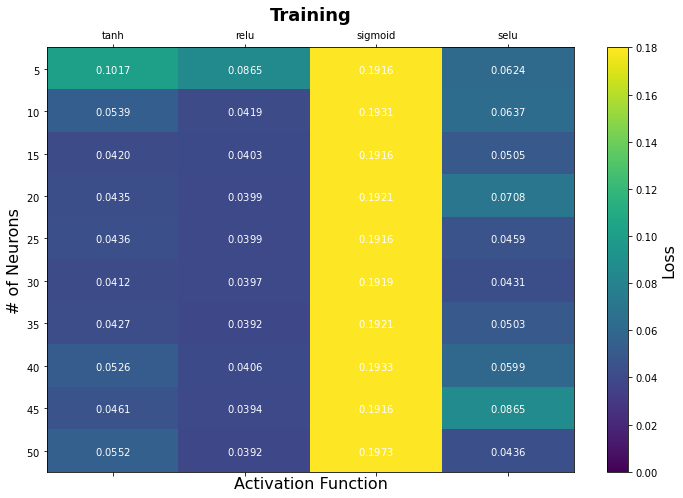

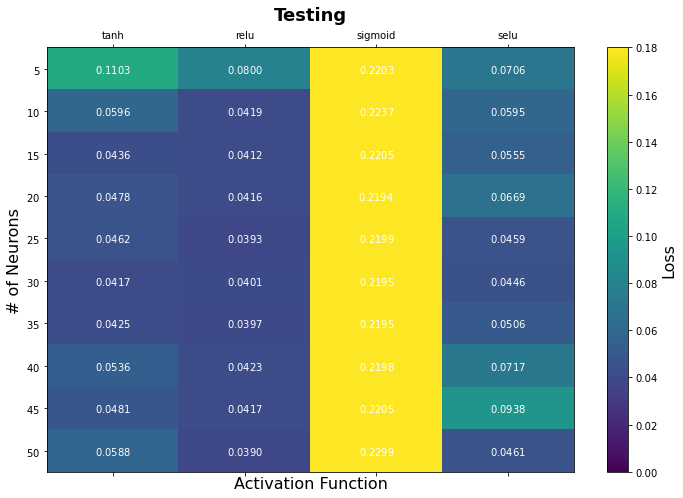

In [6]:
def plot_data_neur_activ(x,y,data,title=None):

    # plot results
    fontsize=16
    
    fig, ax = plt.subplots(figsize = (10,7))
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin = 0, vmax = 0.18,
                     aspect = "auto", cmap="viridis")
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('Loss',rotation=90,fontsize=fontsize)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.4f}$".format(data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center', 
                    color = "white"
                   )

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str("${0:.0f}$".format(i)) for i in y]
    
    ax.set_yticks(np.linspace(0,9,len(y)))


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(y)

    
    
    ax.set_xlabel('Activation Function',fontsize=fontsize)
    ax.set_ylabel('# of Neurons',fontsize=fontsize)
    if title is not None:
        ax.set_title(title, fontsize=fontsize+2,fontweight='bold')

    plt.tight_layout()

    plt.show()

plot_data_neur_activ(activation,n_neuron,Train_loss, 'Training')
plot_data_neur_activ(activation,n_neuron,Test_loss, 'Testing')

La funzione di costo con i risultati migliori è la *relu*; la sigmoide, invece, dà i risultati con funzione di costo nettamente più alta rispetto alle altre funzioni di costo testate. La dipendenza dal numero di neuroni, invece, non è molto marcata: si nota che per un numero di neuroni superiore a $n_{neurons}=5$ non si ha una variazione così elevata nella prestazione.

Procedo aumentando il numero di epoche del risultato migliore ottenuto: $n_{neurons}=50$, *relu*.

In [57]:
DNN_model = NN_model(2,n_layers,50,"relu",optimizer,loss)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0, patience=100, mode='auto')
best_history = DNN_model.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
                         batch_size=32, epochs=200,
                         shuffle=True, # a good idea is to shuffle input before at each epoch
                         validation_data=(np.vstack((x_valid,y_valid)).T,z_valid),
                         callbacks=[earlystop])
        
train_loss = DNN_model.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
test_loss =DNN_model.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]

Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 0.1910 - mse: 0.1910 - val_loss: 0.2048 - val_mse: 0.2048
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1685 - mse: 0.1685 - val_loss: 0.1879 - val_mse: 0.1879
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1573 - mse: 0.1573 - val_loss: 0.1751 - val_mse: 0.1751
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1460 - mse: 0.1460 - val_loss: 0.1598 - val_mse: 0.1598
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1346 - mse: 0.1346 - val_loss: 0.1439 - val_mse: 0.1439
Epoch 6/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1222 - mse: 0.1222 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 7/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1097 - mse: 0.1097 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - 

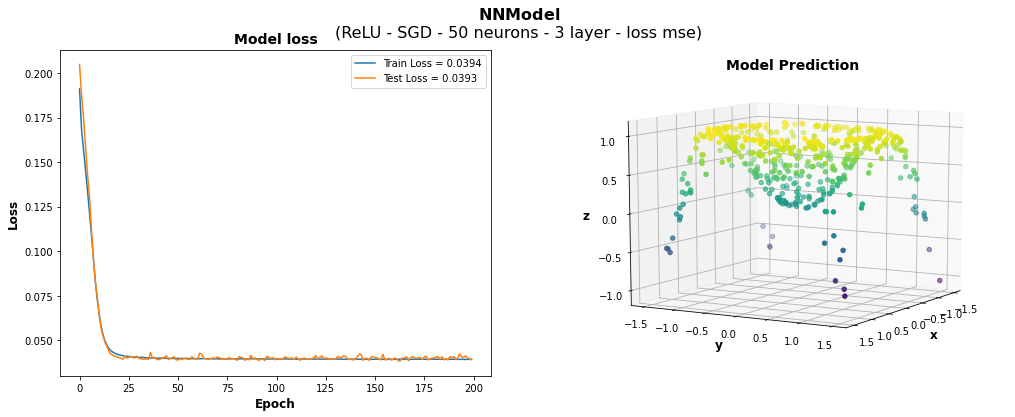

In [59]:
fig = plt.figure(figsize = (17,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

fig.suptitle("$\mathbf{NN Model}$\n(ReLU - SGD - 50 neurons - 3 layer - loss mse)", fontsize=16)

ax1.plot(best_history.history['loss'])
ax1.plot(best_history.history['val_loss'])
ax1.set_title('Model loss', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Loss', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('Epoch', fontsize = 12, fontweight = 'bold')
ax1.legend(['Train Loss = 0.0394', 'Test Loss = 0.0393'], loc='best')

x_predicted = np.random.uniform(-1.5, 1.5, 500)
y_predicted = np.random.uniform(-1.5, 1.5, 500)
z_predicted = DNN_model.predict(np.vstack((x_predicted,y_predicted)).T)

ax2.scatter(x_predicted, y_predicted, z_predicted, c = z_predicted, zorder = 10)

ax2.set_xlabel('x', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('y', fontsize = 12, fontweight = 'bold')
ax2.set_zlabel('z', fontsize = 12, fontweight = 'bold')
ax2.set_title('Model Prediction', fontsize = 14, fontweight = 'bold')
ax2.view_init(10, 30)
plt.show()

Approfondisco la ricerca con una grid search sulla funzione di costo e sull'ottimizzatore. Come funzioni di costo ho utilizzato *mse*, *mae*, *msle* e *logcosh*: quest'ultima, secondo TensorFlow, lavora in modo analogo alla funzione di costo *mse*, ma non è così fortemente affetta da predizioni molto sbagliate.

In [10]:
# Define tunable parameters"
n_layers = 3                                  #Define number of hidden layers in the model
n_neuron = 50                                 #Define number of neurons per layer
epochs = 80                                   #Number of reiterations over the input data
activation = "relu"
loss = ["mse","mae","logcosh","msle"]
optimizer = ["sgd","adam","rmsprop","adagrad","adamax"]


history = []

Train_loss=np.zeros((len(loss),len(optimizer)))      #Define matrices to store accuracy scores as a function
Test_loss=np.zeros((len(loss),len(optimizer)))       #of n_epochs and number of hidden neurons for 

for i in range(len(loss)):     #run loops over hidden neurons and learning rates to calculate 
    row = []
    for j in range(len(optimizer)):      #accuracy scores 
        DNN_model=NN_model(2,n_layers,n_neuron,activation,optimizer[j],loss[i])
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                  min_delta=0, patience=100, mode='auto')

        row.append(DNN_model.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
          batch_size=32, epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
          callbacks=[earlystop]))
        
        Train_loss[i,j]=DNN_model.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
        Test_loss[i,j]=DNN_model.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]
    history.append(row)

Epoch 1/80
313/313 [==============================] - 1s 2ms/step - loss: 0.2099 - mse: 0.2099 - val_loss: 0.2108 - val_mse: 0.2108
Epoch 2/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1786 - val_loss: 0.1990 - val_mse: 0.1990
Epoch 3/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1682 - mse: 0.1682 - val_loss: 0.1877 - val_mse: 0.1877
Epoch 4/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1558 - mse: 0.1558 - val_loss: 0.1750 - val_mse: 0.1750
Epoch 5/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1432 - mse: 0.1432 - val_loss: 0.1587 - val_mse: 0.1587
Epoch 6/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.1399 - val_mse: 0.1399
Epoch 7/80
313/313 [==============================] - 0s 1ms/step - loss: 0.1137 - mse: 0.1137 - val_loss: 0.1202 - val_mse: 0.1202
Epoch 8/80
313/313 [==============================] - 0s 1ms/step - loss: 0.

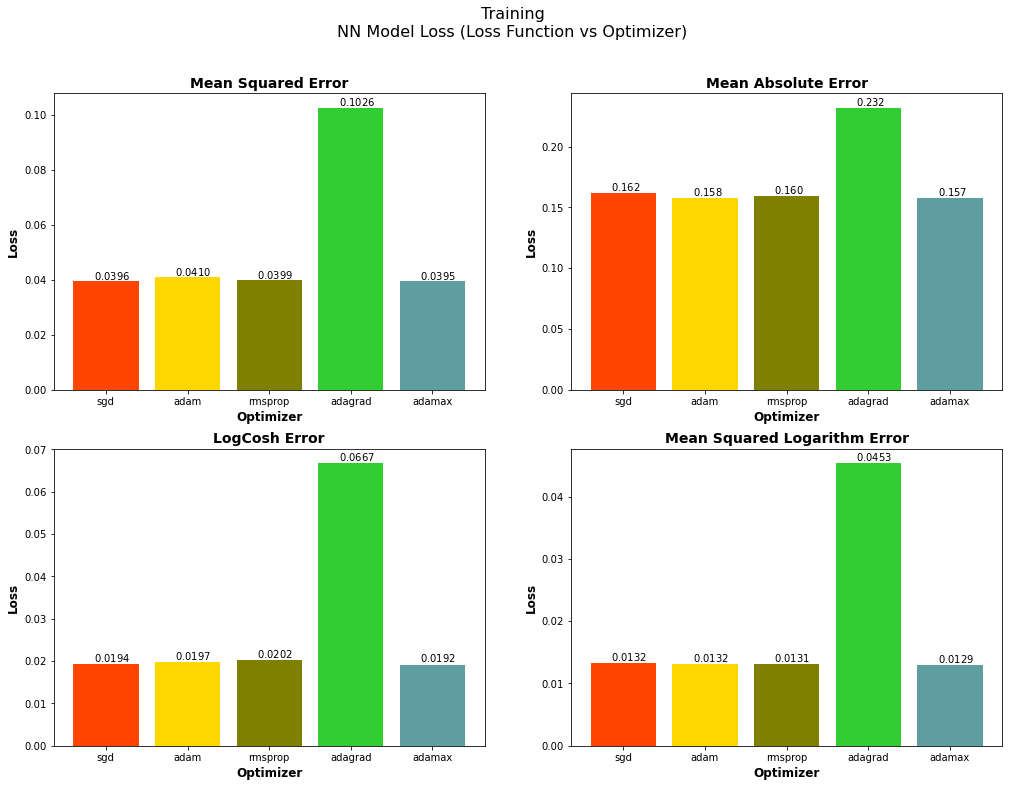

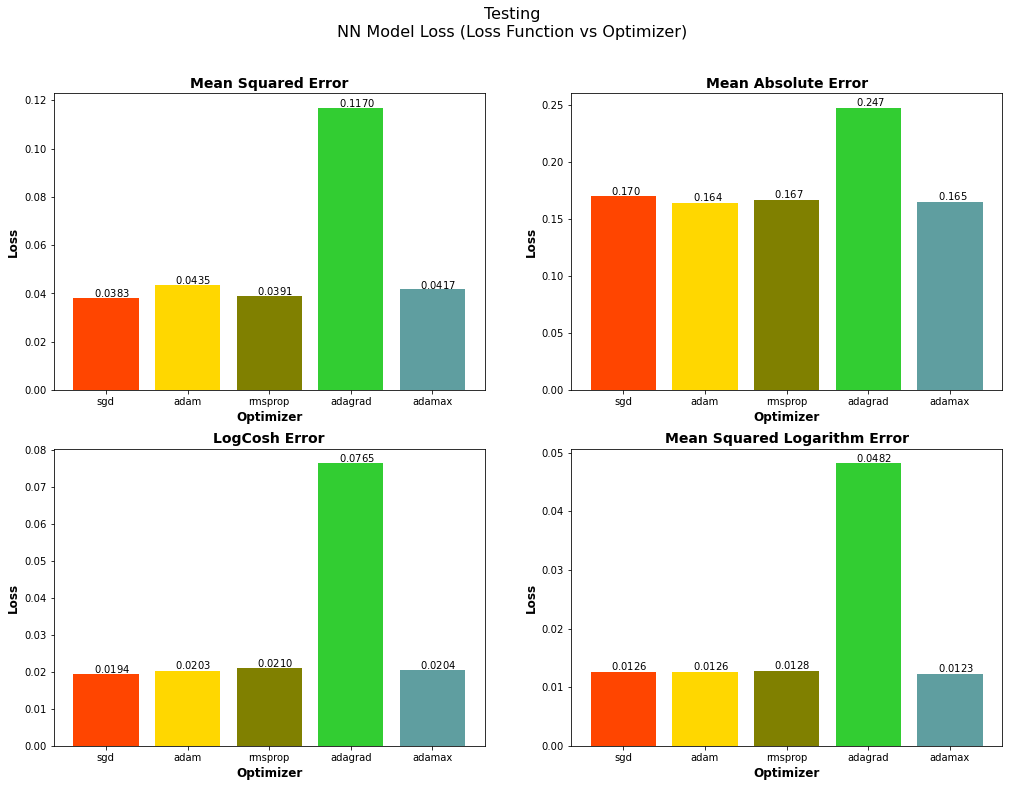

In [45]:
def plot_data_loss_optim(data,title=None):

    # plot results
    fontsize=16
    
    fig, ax = plt.subplots(2, 2, figsize=(17, 12))
    fig.suptitle(title+"\nNN Model Loss (Loss Function vs Optimizer)", fontsize=fontsize)
    
    colors = ["orangered","gold","olive","limegreen","cadetblue"]
    
    x = np.arange(len(optimizer))
    y = data[0]
    ax[0][0].set_xticklabels(['']+optimizer)
    ax[0][0].bar(x, y, color=colors)
    for i, v in enumerate(y):
        ax[0][0].text( i-0.15,v + 0.002, str("${0:.4f}$".format(v)),va = "center", fontweight='bold')    
    y = data[1]    
    ax[0][1].set_xticklabels(['']+optimizer)
    ax[0][1].bar(x, y, color=colors)
    for i, v in enumerate(y):
        ax[0][1].text( i-0.15,v + 0.005, str("${0:.3f}$".format(v)),va = "center", fontweight='bold')
    y = data[2]    
    ax[1][0].set_xticklabels(['']+optimizer)
    for i, v in enumerate(y):
        ax[1][0].text( i-0.15,v + 0.0015, str("${0:.4f}$".format(v)),va = "center", fontweight='bold')
    ax[1][0].bar(x, y, color=colors)

    y = data[3]    
    ax[1][1].set_xticklabels(['']+optimizer)
    ax[1][1].bar(x, y, color=colors)
    for i, v in enumerate(y):
        ax[1][1].text( i-0.15,v + 0.001, str("${0:.4f}$".format(v)),va = "center", fontweight='bold')

    
    ax[0][0].set_title('Mean Squared Error', fontsize = fontsize - 2, fontweight = 'bold')
    ax[0][0].set_ylabel('Loss', fontsize = fontsize - 4, fontweight = 'bold')
    ax[0][0].set_xlabel('Optimizer', fontsize = fontsize - 4, fontweight = 'bold')
    
    ax[0][1].set_title('Mean Absolute Error', fontsize = fontsize - 2, fontweight = 'bold')
    ax[0][1].set_ylabel('Loss', fontsize = fontsize - 4, fontweight = 'bold')
    ax[0][1].set_xlabel('Optimizer', fontsize = fontsize - 4, fontweight = 'bold')
    
    ax[1][0].set_title('LogCosh Error', fontsize = fontsize - 2, fontweight = 'bold')
    ax[1][0].set_ylabel('Loss', fontsize = fontsize - 4, fontweight = 'bold')
    ax[1][0].set_xlabel('Optimizer', fontsize = fontsize - 4, fontweight = 'bold')
    
    ax[1][1].set_title('Mean Squared Logarithm Error', fontsize = fontsize - 2, fontweight = 'bold')
    ax[1][1].set_ylabel('Loss', fontsize = fontsize - 4, fontweight = 'bold')
    ax[1][1].set_xlabel('Optimizer', fontsize = fontsize - 4, fontweight = 'bold')
    
    plt.show()

plot_data_loss_optim(Train_loss, 'Training')
plot_data_loss_optim(Test_loss, 'Testing')

Procedo aumentando le epoche delle coppie di parametri che hanno dato i migliori risultati:

In [46]:
DNN_model1 = NN_model(2,n_layers,50,"relu","sgd","mse")
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0, patience=100, mode='auto')
best_history1 = DNN_model1.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
                         batch_size=32, epochs=200,
                         shuffle=True, # a good idea is to shuffle input before at each epoch
                         validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
                         callbacks=[earlystop])
train_loss1 = DNN_model1.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
test_loss1 =DNN_model1.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]

DNN_model2 = NN_model(2,n_layers,50,"relu","adam","mae")
best_history2 = DNN_model2.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
                         batch_size=32, epochs=200,
                         shuffle=True, # a good idea is to shuffle input before at each epoch
                         validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
                         callbacks=[earlystop])
train_loss2 = DNN_model2.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
test_loss2 =DNN_model2.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]

DNN_model3 = NN_model(2,n_layers,45,"relu","sgd","logcosh")
best_history3 = DNN_model3.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
                         batch_size=32, epochs=200,
                         shuffle=True, # a good idea is to shuffle input before at each epoch
                         validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
                         callbacks=[earlystop])
train_loss3 = DNN_model3.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
test_loss3 =DNN_model3.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]

DNN_model4 = NN_model(2,n_layers,45,"relu","adamax","msle")
best_history4 = DNN_model4.fit(x=np.vstack((x_train,y_train)).T, y=z_train, 
                         batch_size=32, epochs=200,
                         shuffle=True, # a good idea is to shuffle input before at each epoch
                         validation_data=(np.vstack((x_valid,y_valid)).T, z_valid),
                         callbacks=[earlystop])
train_loss4 = DNN_model4.evaluate(np.vstack((x_train,y_train)).T,z_train)[0]
test_loss4 = DNN_model4.evaluate(np.vstack((x_valid,y_valid)).T,z_valid)[0]

Epoch 1/200
313/313 [==============================] - 0s 2ms/step - loss: 0.2004 - mse: 0.2004 - val_loss: 0.2144 - val_mse: 0.2144
Epoch 2/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1762 - mse: 0.1762 - val_loss: 0.2018 - val_mse: 0.2018
Epoch 3/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1682 - mse: 0.1682 - val_loss: 0.1939 - val_mse: 0.1939
Epoch 4/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1601 - mse: 0.1601 - val_loss: 0.1826 - val_mse: 0.1826
Epoch 5/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1519 - mse: 0.1519 - val_loss: 0.1712 - val_mse: 0.1712
Epoch 6/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1434 - mse: 0.1434 - val_loss: 0.1613 - val_mse: 0.1613
Epoch 7/200
313/313 [==============================] - 0s 1ms/step - loss: 0.1342 - mse: 0.1342 - val_loss: 0.1501 - val_mse: 0.1501
Epoch 8/200
313/313 [==============================] - 0s 1ms/step - 

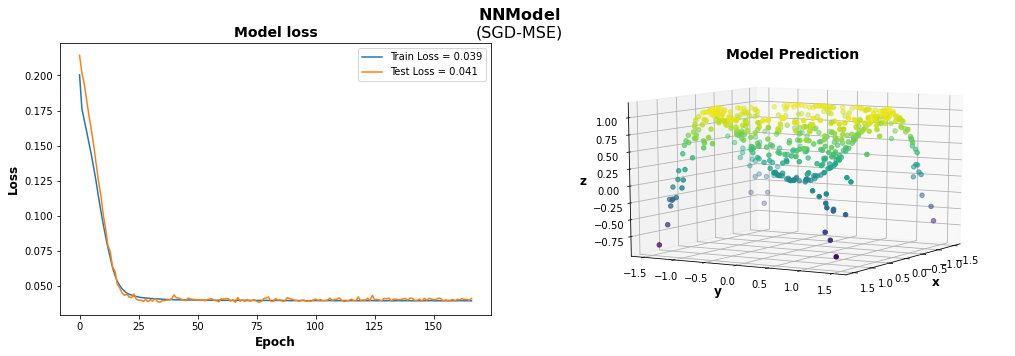

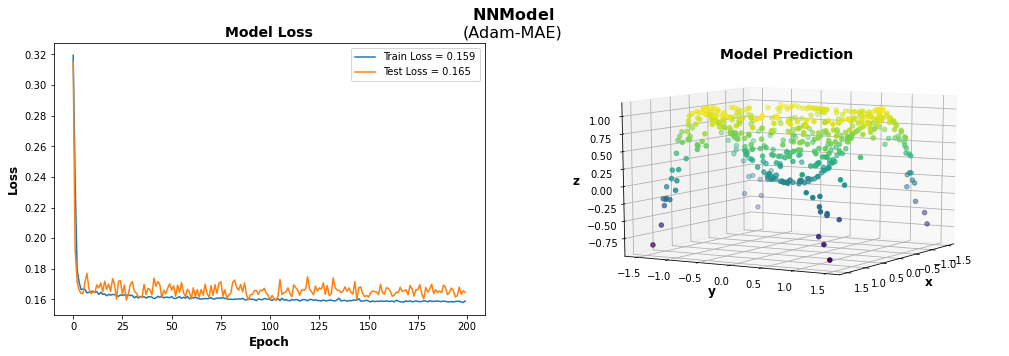

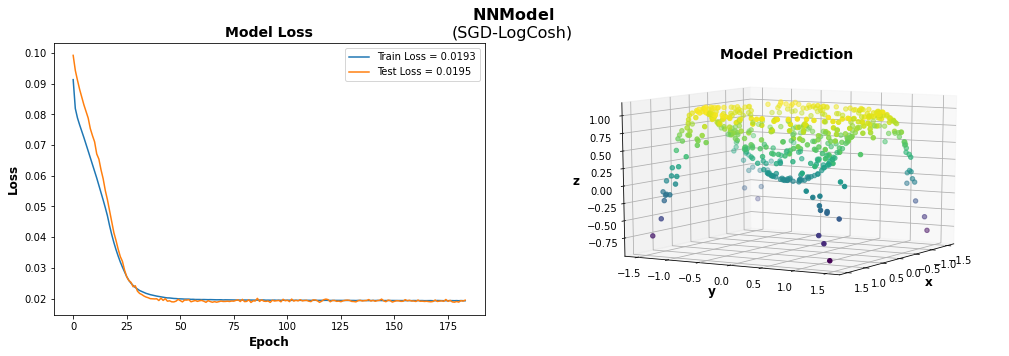

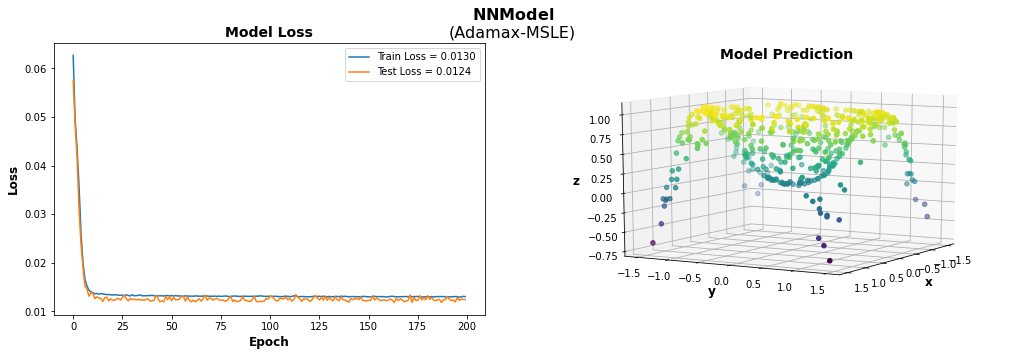

In [56]:
fig = plt.figure(figsize = (17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

fig.suptitle("$\mathbf{NN Model}$\n(SGD-MSE)", fontsize=16)

ax1.plot(best_history1.history['loss'])
ax1.plot(best_history1.history['val_loss'])
ax1.set_title('Model loss', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Loss', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('Epoch', fontsize = 12, fontweight = 'bold')
ax1.legend(['Train Loss = 0.039', 'Test Loss = 0.041'], loc='best')


x_predicted = np.random.uniform(-1.5, 1.5, 500)
y_predicted = np.random.uniform(-1.5, 1.5, 500)
z_predicted = DNN_model1.predict(np.vstack((x_predicted,y_predicted)).T)

ax2.scatter(x_predicted, y_predicted, z_predicted, c = z_predicted, zorder = 10)
ax2.set_xlabel('x', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('y', fontsize = 12, fontweight = 'bold')
ax2.set_zlabel('z', fontsize = 12, fontweight = 'bold')
ax2.set_title('Model Prediction', fontsize = 14, fontweight = 'bold')
ax2.view_init(10, 30)
plt.show()


fig = plt.figure(figsize = (17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

fig.suptitle("$\mathbf{NN Model}$\n(Adam-MAE)", fontsize=16)

ax1.plot(best_history2.history['loss'])
ax1.plot(best_history2.history['val_loss'])
ax1.set_title('Model Loss', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Loss', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('Epoch', fontsize = 12, fontweight = 'bold')
ax1.legend(['Train Loss = 0.159', 'Test Loss = 0.165'], loc='best')


z_predicted = DNN_model2.predict(np.vstack((x_predicted,y_predicted)).T)

ax2.scatter(x_predicted, y_predicted, z_predicted, c = z_predicted, zorder = 10)
ax2.set_xlabel('x', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('y', fontsize = 12, fontweight = 'bold')
ax2.set_zlabel('z', fontsize = 12, fontweight = 'bold')
ax2.set_title('Model Prediction', fontsize = 14, fontweight = 'bold')
ax2.view_init(10, 30)
plt.show()


fig = plt.figure(figsize = (17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')


fig.suptitle("$\mathbf{NN Model}$\n(SGD-LogCosh)", fontsize=16)

ax1.plot(best_history3.history['loss'])
ax1.plot(best_history3.history['val_loss'])
ax1.set_title('Model Loss', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Loss', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('Epoch', fontsize = 12, fontweight = 'bold')
ax1.legend(['Train Loss = 0.0193', 'Test Loss = 0.0195'], loc='best')


z_predicted = DNN_model3.predict(np.vstack((x_predicted,y_predicted)).T)

ax2.scatter(x_predicted, y_predicted, z_predicted, c = z_predicted, zorder = 10)
ax2.set_xlabel('x', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('y', fontsize = 12, fontweight = 'bold')
ax2.set_zlabel('z', fontsize = 12, fontweight = 'bold')
ax2.set_title('Model Prediction', fontsize = 14, fontweight = 'bold')
ax2.view_init(10, 30)
plt.show()

fig = plt.figure(figsize = (17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')


fig.suptitle("$\mathbf{NN Model}$\n(Adamax-MSLE)", fontsize=16)

ax1.plot(best_history4.history['loss'])
ax1.plot(best_history4.history['val_loss'])
ax1.set_title('Model Loss', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Loss', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('Epoch', fontsize = 12, fontweight = 'bold')
ax1.legend(['Train Loss = 0.0130', 'Test Loss = 0.0124'], loc='best')

z_predicted = DNN_model4.predict(np.vstack((x_predicted,y_predicted)).T)

ax2.scatter(x_predicted, y_predicted, z_predicted, c = z_predicted, zorder = 10)
ax2.set_xlabel('x', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('y', fontsize = 12, fontweight = 'bold')
ax2.set_zlabel('z', fontsize = 12, fontweight = 'bold')
ax2.set_title('Model Prediction', fontsize = 14, fontweight = 'bold')
ax2.view_init(10, 30)
plt.show()



Data la natura tridimensionale del problema, risulta abbastanza complesso valutare l'accuratezza delle previsioni effettuate; tuttavia, tutti e quattro i modelli finali sembrano ottenere buoni risultati.